In [1]:
!pip install transformers
!pip install matplotlib scikit-learn

In [2]:
from google.colab import files
import pandas as pd

# Upload the dataset
uploaded = files.upload()

# Load the dataset into a pandas dataframe
df = pd.read_csv(next(iter(uploaded)))

# Display the first few rows to understand the structure
df.head()


Saving LLM_dataset.csv to LLM_dataset.csv


,x_i,x_j,Label
0,he held her back and,"whispered urgently for her to stay calm, sensi...",GPT4o
1,none of her previous boyfriends had,had lasted this long.,GPT4o
2,"our clothes quickly disappeared , until we stood",naked in the moonlight.,GPT4o
3,but dagmar was not some mindless,follower; she had a plan.,GPT4o
4,"she paused , obviously",uncertain of what to say next.,GPT4o


In [3]:
# Check for missing values
df.isnull().sum()

# Combine `x_i` and `x_j` into a single text field
df['combined_text'] = df['x_i'] + ' ' + df['x_j']

# View a few rows of the combined text and labels
df[['combined_text', 'Label']].head()


,combined_text,Label
0,he held her back and whispered urgently for he...,GPT4o
1,none of her previous boyfriends had had lasted...,GPT4o
2,"our clothes quickly disappeared , until we sto...",GPT4o
3,but dagmar was not some mindless follower; she...,GPT4o
4,"she paused , obviously uncertain of what to sa...",GPT4o


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['combined_text'], df['Label'], test_size=0.2, random_state=42)


In [14]:
from transformers import AlbertTokenizer
print(X_train[:5])
# Load ALBERT tokenizer and model for sequence classification
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]
# Tokenize the training and testing data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='pt')


["i was n't sure if he was stunned he was simply shocked.", 'foley stood in her open doorway , a candle in in her hand, casting flickering shadows on the walls.', ' but it ties in into the greater scheme of things.', 'she backed up hastily , and the scarf ed her twice, and she turned and cuffering.', 'i unwound myself from him and could myself from the warmth.']


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert labels to list form
y_train = pd.Series(y_train).astype('category').cat.codes.tolist()  # Encode categories as numerical codes
y_test = pd.Series(y_test).astype('category').cat.codes.tolist()

# Create PyTorch datasets
train_dataset = TextDataset(train_encodings, y_train)
test_dataset = TextDataset(test_encodings, y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [32]:
from transformers import AlbertForSequenceClassification, AdamW

# Load the pre-trained ALBERT model for classification
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=5)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [33]:
from tqdm import tqdm

# Training loop
model.train()
for epoch in range(3):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # Move batch data to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())


  0%|          | 0/625 [00:00<?, ?it/s]<ipython-input-31-b26948a2aa1c>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████| 625/625 [05:20<00:00,  1.95it/s, loss=1.14]


In [34]:
from sklearn.metrics import accuracy_score, classification_report

# Put the model in evaluation mode
model.eval()

# Define the class names in the same order as the numerical labels
class_names = ['GPT2', 'GPT4o', 'GPT_NEO', 'Gemini', 'Reformer']

# Collect all predictions and labels
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Get predictions
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        # Store predictions and true labels
        preds.extend(predictions)
        true_labels.extend(labels)

# Calculate accuracy and print classification report
accuracy = accuracy_score(true_labels, preds)
print(f'Accuracy: {accuracy}')
print(classification_report(true_labels, preds, target_names=class_names))


<ipython-input-31-b26948a2aa1c>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.4362
              precision    recall  f1-score   support

        GPT2       0.46      0.56      0.51      1000
       GPT4o       0.59      0.28      0.38      1021
     GPT_NEO       0.27      0.31      0.29       989
      Gemini       0.40      0.37      0.39      1005
    Reformer       0.53      0.67      0.59       985

    accuracy                           0.44      5000
   macro avg       0.45      0.44      0.43      5000
weighted avg       0.45      0.44      0.43      5000



In [35]:
import random

# X_test as lists
class_names = ['GPT2', 'GPT4o', 'GPT_NEO', 'Gemini', 'Reformer']

# Randomly choose 10 indices from the test set
random_indices = random.sample(range(len(X_test)), 10)

# Show the true label, predicted label, and whether they match
for idx in random_indices:
    # Get the text, true label, and predicted label for the selected index
    text = X_test[idx]  # Use X_test[idx]
    true_label = class_names[true_labels[idx]]  # Convert true label from int to class name
    predicted_label = class_names[preds[idx]]  # Convert predicted label from int to class name

    # Display the text, true label, predicted label, and whether they match
    print(f"Text: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Match: {true_label == predicted_label}")
    print('-' * 80)


Text: it went right up into the dome above the dome.
True Label: GPT_NEO
Predicted Label: GPT2
Match: False
--------------------------------------------------------------------------------
Text: definitely not as big , but about half the size I expected.
True Label: Gemini
Predicted Label: Gemini
Match: True
--------------------------------------------------------------------------------
Text: rafe shrugged as if time-traveling had been a problem.
True Label: GPT_NEO
Predicted Label: GPT_NEO
Match: True
--------------------------------------------------------------------------------
Text:  there are not many reporters left , but is there a story waiting to be uncovered.
True Label: Gemini
Predicted Label: Gemini
Match: True
--------------------------------------------------------------------------------
Text: at a friends home you can watch a tv and he took a moment.
True Label: GPT4o
Predicted Label: Reformer
Match: False
---------------------------------------------------------------

In [36]:
df['Label'] = df['Label'].astype('category')

# Print the mapping of categories to numbers
print(dict(enumerate(df['Label'].cat.categories)))


{0: 'GPT2', 1: 'GPT4o', 2: 'GPT_NEO', 3: 'Gemini', 4: 'Reformer'}


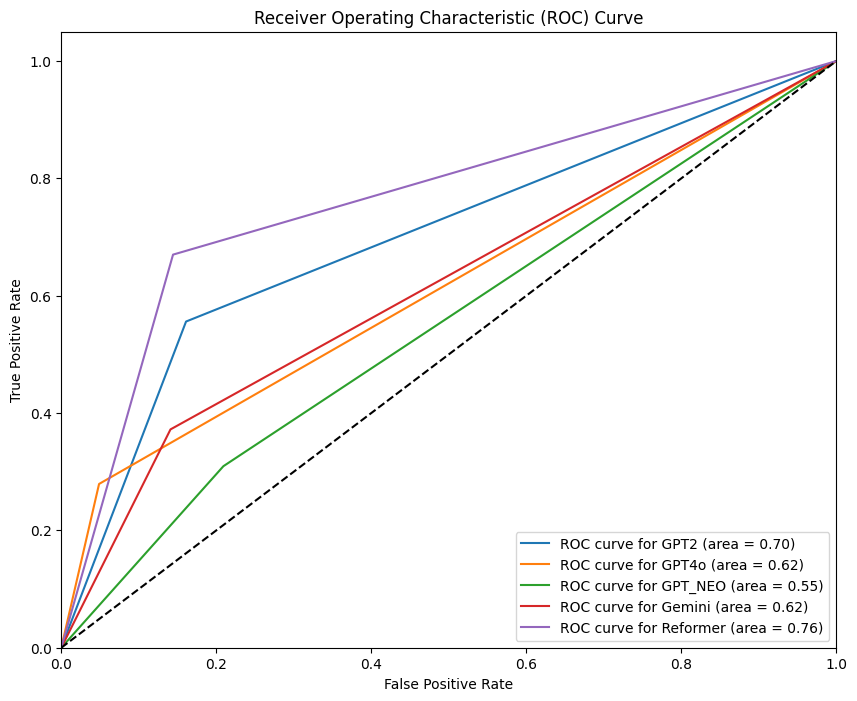

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Convert the true labels and predicted labels to their one-hot encoded (binarized) form
y_true_binarized = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
y_pred_binarized = label_binarize(preds, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
